# Testing surface attribute calculation
## Introduction
There are different methods available to calculate both gradient (slope steepness and slope direction) and curvature attributes of a given surface.

The EIS-toolkit contains following defaults, however, they're interchangeable to some point. Results of each calculation returns a dictionary containing the names (key) and respective arrays and metadata (tuple).


## Examples

### Set-up

In [1]:
# Modules and basic set-up
import numpy as np
import os
import rasterio

import sys
sys.path.append('..')

from eis_toolkit.utilities.nodata import nodata_to_nan
from eis_toolkit.raster_processing.derivatives.parameters import first_order, second_order_basic_set
from eis_toolkit.raster_processing.derivatives.classification import classify_aspect
from eis_toolkit.utilities.conversions import convert_deg_to_rad, convert_rad_to_deg
from eis_toolkit.utilities.nodata import nodata_to_nan

np.set_printoptions(suppress=True)

# Path to data
file_paths = ['../tests/data/remote/small_raster.tif']

# Select data
file_path = file_paths[0]

file_name = os.path.splitext(os.path.basename(file_path))[0]   
results_path = '../tests/data/local/results/surface_derivatives/'
results_basename = os.path.basename(file_path).split('.')[0]
results_ext = ".tif"

raster = rasterio.open(file_path)
nodata_replacement = -9999


/root/.cache/pypoetry/virtualenvs/eis-toolkit-QEzTY9B6-py3.10/lib/python3.10/site-packages/beartype/_util/hint/pep/utilpeptest.py:347: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Sequence[str] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


### Helper

In [2]:
import math
import matplotlib.pyplot as plt

# Plotting
def plots_side_by_side(box_width, box_heigth, *argv):
    """Plot multiple images side by side"""
    num_cols = 5
    
    if isinstance(argv[0], str):
      num_images = 1
    elif isinstance(argv[0], tuple):
      num_images = len(argv)
            
    num_rows = math.ceil(num_images/num_cols)
    
    plt.figure(figsize=(box_width*num_cols, box_heigth*num_rows))

    for i in range(0, num_images):
      parameter = argv[i][0] if num_images > 1 else argv[0]
      image = argv[i][1] if num_images > 1 else argv[1]

      plt.subplot(num_rows, num_cols, i+1)
      plt.subplots_adjust(wspace=0.1, hspace=0)
      plt.title(parameter)
      plt.axis("off")
      plt.imshow(image, cmap='viridis')
      plt.colorbar(location='right', shrink=0.5, pad=0.02);
      
      i += 1
      
      
# Exporting
def export_raster(array, name, meta=None, export=True, path=results_path):
    if export is True:  
      file_path = path + name + '.tif'
      
      if meta is not None:
          with rasterio.open(file_path, 'w', **meta) as dst:
              dst.write(np.float32(array), 1)
      else:
          with rasterio.open(file_path, 'w', driver='GTiff', 
                          height=array.shape[0], width=array.shape[1], 
                          count=1, dtype=np.float32) as dst:
              dst.write(array, 1)

### First order derivatives

#### Horn (1981)
Slope and Aspect in degrees.

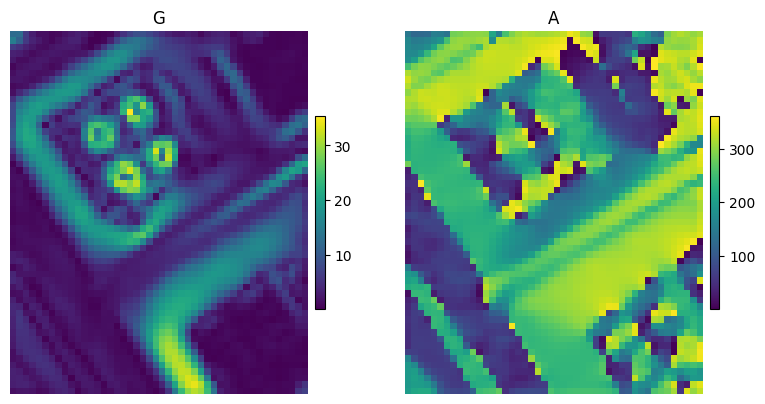

In [3]:
# Calculation of slope and aspect in degrees
gradient = first_order(raster, parameters=["G", "A"], slope_gradient_unit="degrees", slope_direction_unit="degrees")

slope = gradient["G"][0]
#slope = nodata_to_nan(slope, nodata_replacement)

aspect = gradient["A"][0]
#aspect = nodata_to_nan(aspect, nodata_replacement)

plots_side_by_side(5, 5, ("G", nodata_to_nan(slope, nodata_replacement)), ("A", nodata_to_nan(aspect, nodata_replacement)))

# Export 
export = False
export_raster(slope, f"horn_{results_basename}_G", gradient["G"][1], export=export)
export_raster(aspect, f"horn_{results_basename}_A", gradient["A"][1], export=export)

#### Zevenbergen & Thorne (1987)
Slope and Aspect in degrees.

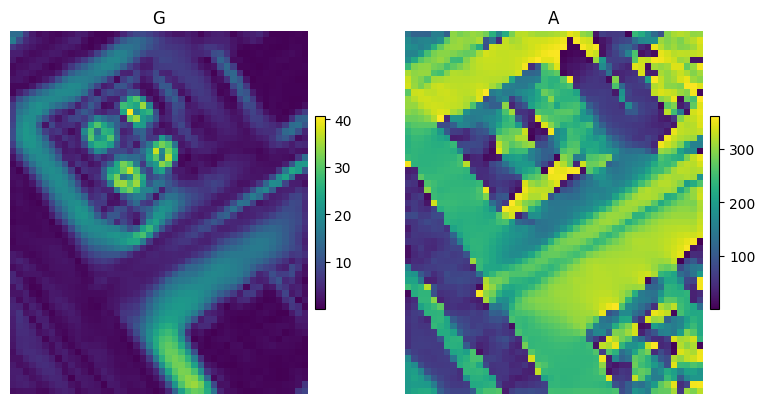

In [4]:
# Calculation of slope and aspect in degrees
gradient = first_order(raster, parameters=["G", "A"], slope_gradient_unit="degrees", slope_direction_unit="degrees", method="Zevenbergen")

slope = gradient["G"][0]
aspect = gradient["A"][0]

plots_side_by_side(5, 5, ("G", nodata_to_nan(slope, nodata_replacement)), ("A", nodata_to_nan(aspect, nodata_replacement)))

# Export 
export = False
export_raster(slope, f"zt_{results_basename}_G", gradient["G"][1], export=export)
export_raster(aspect, f"zt_{results_basename}_A", gradient["A"][1], export=export)

#### Evans-Young (1978/1979)
Slope and Aspect in degrees.

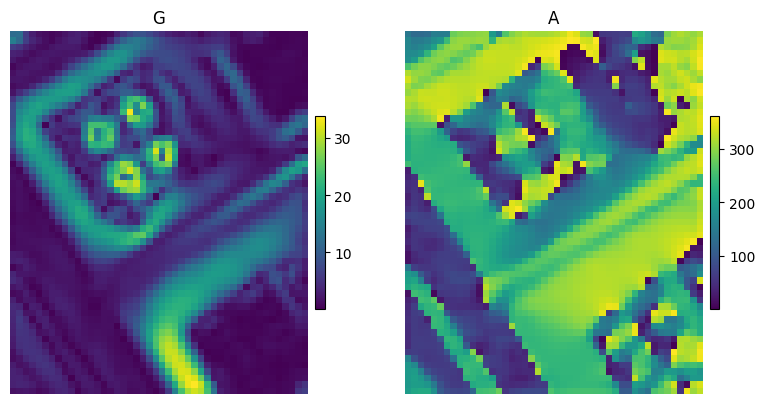

In [5]:
# Calculation of slope and aspect in degrees
gradient = first_order(raster, parameters=["G", "A"], slope_gradient_unit="degrees", slope_direction_unit="degrees", method="Young")

slope = gradient["G"][0]
aspect = gradient["A"][0]

plots_side_by_side(5, 5, ("G", nodata_to_nan(slope, nodata_replacement)), ("A", nodata_to_nan(aspect, nodata_replacement)))

# Export 
export = False
export_raster(slope, f"young_{results_basename}_G", gradient["G"][1], export=export)
export_raster(aspect, f"young_{results_basename}_A", gradient["A"][1], export=export)

#### Evans (1979)
Slope and Aspect in degrees with **slope_tolerance = 10** degrees.

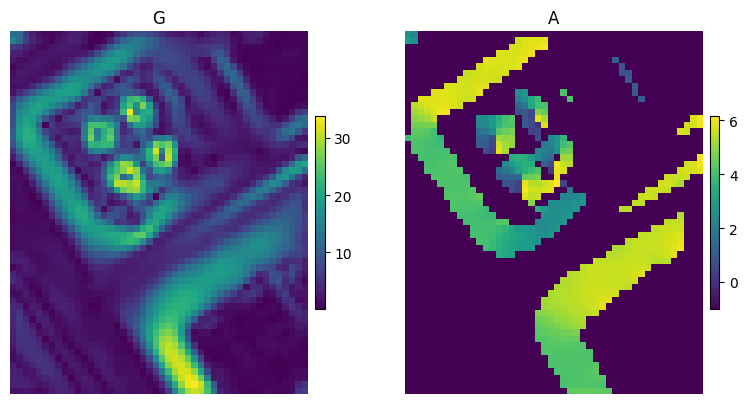

In [6]:
# Calculation of slope and aspect in degrees
gradient = first_order(raster, parameters=["G", "A"], slope_tolerance=10, slope_gradient_unit="degrees", slope_direction_unit="radians", method="Evans")

slope = gradient["G"][0]
aspect = gradient["A"][0]

plots_side_by_side(5, 5, ("G", nodata_to_nan(slope, nodata_replacement)), ("A", nodata_to_nan(aspect, nodata_replacement)))

# Export 
export = False
export_raster(slope, f"evans_{results_basename}_G", gradient["G"][1], export=export)
export_raster(aspect, f"evans_{results_basename}_A", gradient["A"][1], export=export)

### Aspect classification

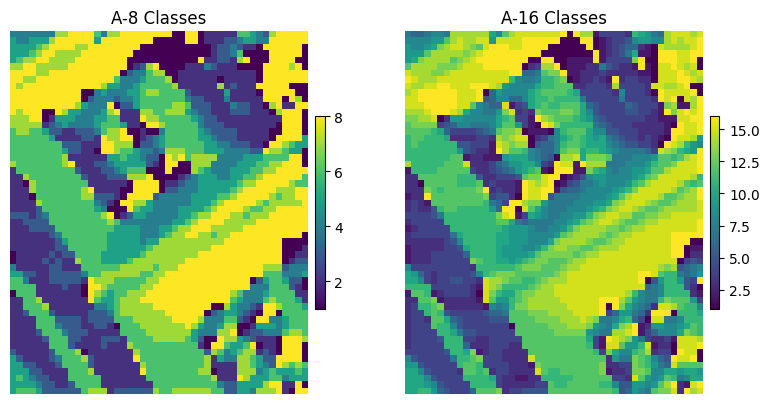

In [7]:
# Calculation of slope and aspect in degrees
aspect = first_order(raster, parameters=["A"], slope_direction_unit="radians", method="Horn")

aspect_array = aspect["A"][0]
aspect_meta = aspect["A"][1]


memory_file = rasterio.MemoryFile()
with memory_file.open(**aspect_meta) as dst:
  dst.write(aspect_array, 1)

with memory_file.open() as aspect:
  classification_array8, classification_mapping8, classification_meta8 = classify_aspect(aspect, num_classes=8, unit="radians")
  classification_array16, classification_mapping16, classification_meta16 = classify_aspect(aspect, num_classes=16, unit="radians")
  
plots_side_by_side(5, 5, ("A-8 Classes", nodata_to_nan(classification_array8, nodata_replacement)), ("A-16 Classes", nodata_to_nan(classification_array16, nodata_replacement)))


### Second order basic curvatures
#### Zevenbergen & Thorne (1987)

In [8]:
second_order = second_order_basic_set(raster, parameters=["planc", "profc", "profc_min", "profc_max", "longc", "crosc", "rot", "K", "genc", "tangc"], method="Zevenbergen")

clip_percentile = 5

planc = second_order["planc"][0]
planc_clip = np.clip(planc, np.percentile(planc, clip_percentile), np.percentile(planc, 100-clip_percentile))

profc = second_order["profc"][0]
profc_min = second_order["profc_min"][0]
profc_max = second_order["profc_max"][0]
longc = second_order["longc"][0]
crosc = second_order["crosc"][0]
rot = second_order["rot"][0]
K =  second_order["K"][0]
genc = second_order["genc"][0]
tangc = second_order["tangc"][0]


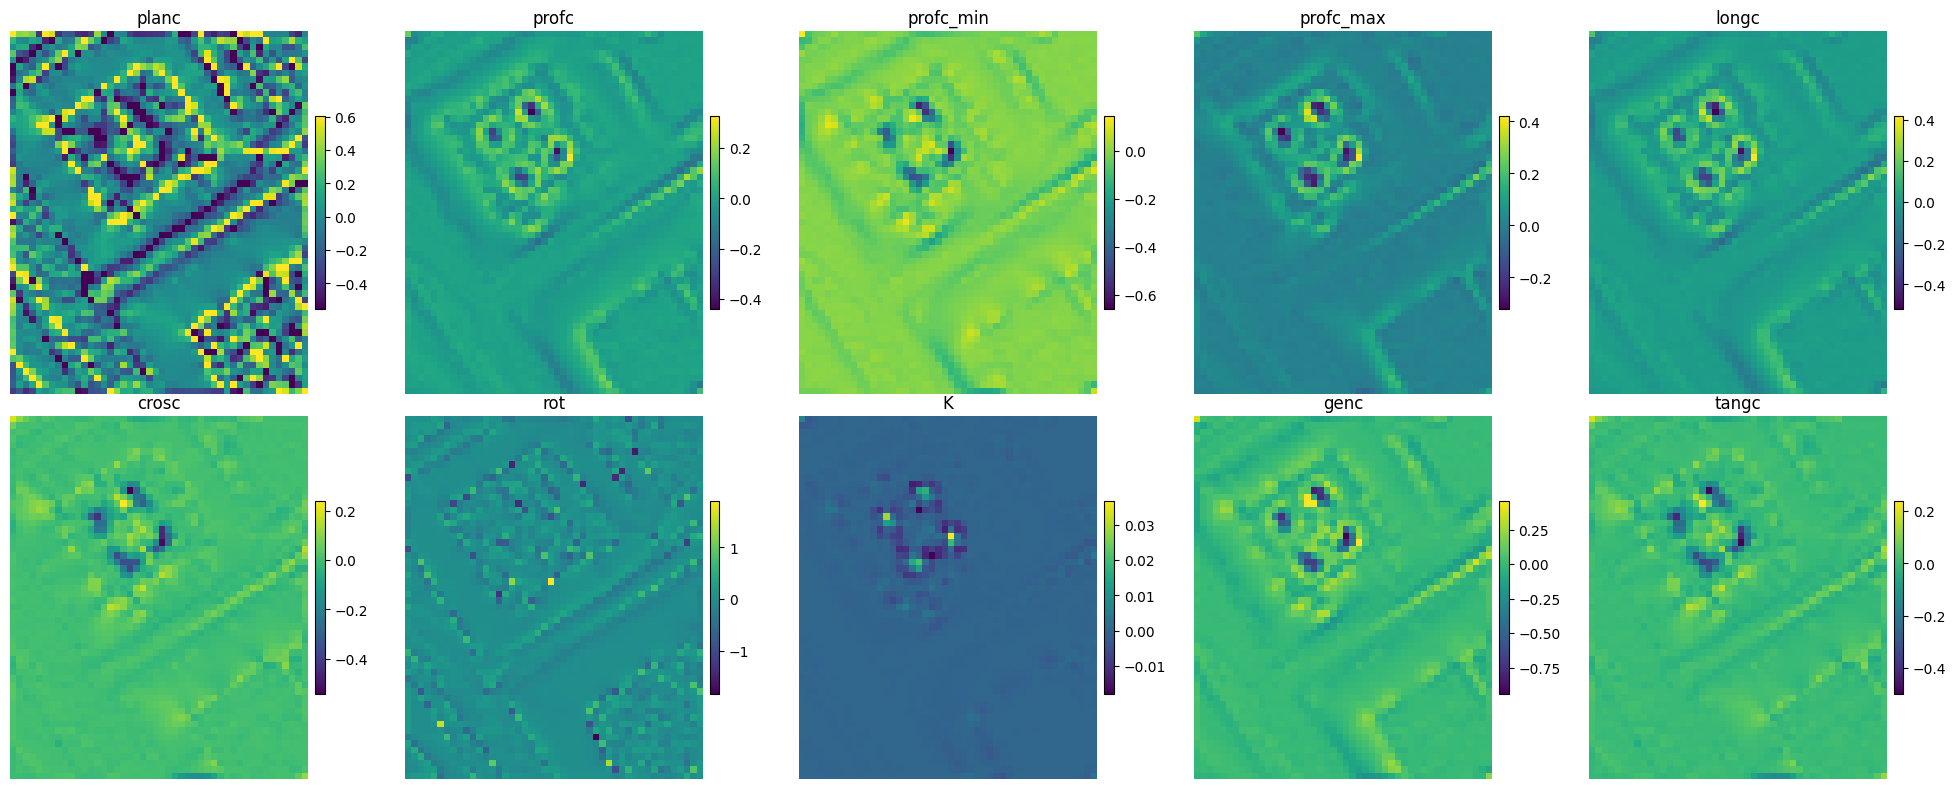

In [9]:
# Plotting
plots_side_by_side(5, 5, 
                   ("planc", nodata_to_nan(planc_clip, nodata_replacement)), 
                   ("profc", nodata_to_nan(profc, nodata_replacement)), 
                   ("profc_min", nodata_to_nan(profc_min, nodata_replacement)), 
                   ("profc_max", nodata_to_nan(profc_max, nodata_replacement)), 
                   ("longc", nodata_to_nan(longc, nodata_replacement)), 
                   ("crosc", nodata_to_nan(crosc, nodata_replacement)), 
                   ("rot", nodata_to_nan(rot, nodata_replacement)), 
                   ("K", nodata_to_nan(K, nodata_replacement)), 
                   ("genc", nodata_to_nan(genc, nodata_replacement)), 
                   ("tangc", nodata_to_nan(tangc, nodata_replacement)))


In [10]:
# Export 
export = False
export_raster(planc, f"zt_{results_basename}_planc", second_order["planc"][1], export=export)
export_raster(profc, f"zt_{results_basename}_profc", second_order["profc"][1], export=export)
export_raster(profc_min, f"zt_{results_basename}_profc_min", second_order["profc_min"][1], export=export)
export_raster(profc_max, f"zt_{results_basename}_profc_max", second_order["profc_max"][1], export=export)
export_raster(longc, f"zt_{results_basename}_longc", second_order["longc"][1], export=export)
export_raster(crosc, f"zt_{results_basename}_crosc", second_order["crosc"][1], export=export)
export_raster(rot, f"zt_{results_basename}_rot", second_order["rot"][1], export=export)
export_raster(K, f"zt_{results_basename}_K", second_order["K"][1], export=export)
export_raster(genc, f"zt_{results_basename}_genc", second_order["genc"][1], export=export)
export_raster(tangc, f"zt_{results_basename}_tangc", second_order["tangc"][1], export=export)


#### Evans-Young (1978/1979)

In [11]:
second_order = second_order_basic_set(raster, parameters=["planc", "profc", "profc_min", "profc_max", "longc", "crosc", "rot", "K", "genc", "tangc"], method="Young")

planc = second_order["planc"][0]
profc = second_order["profc"][0]
profc_min = second_order["profc_min"][0]
profc_max = second_order["profc_max"][0]
longc = second_order["longc"][0]
crosc = second_order["crosc"][0]
rot = second_order["rot"][0]
K =  second_order["K"][0]
genc = second_order["genc"][0]
tangc = second_order["tangc"][0]


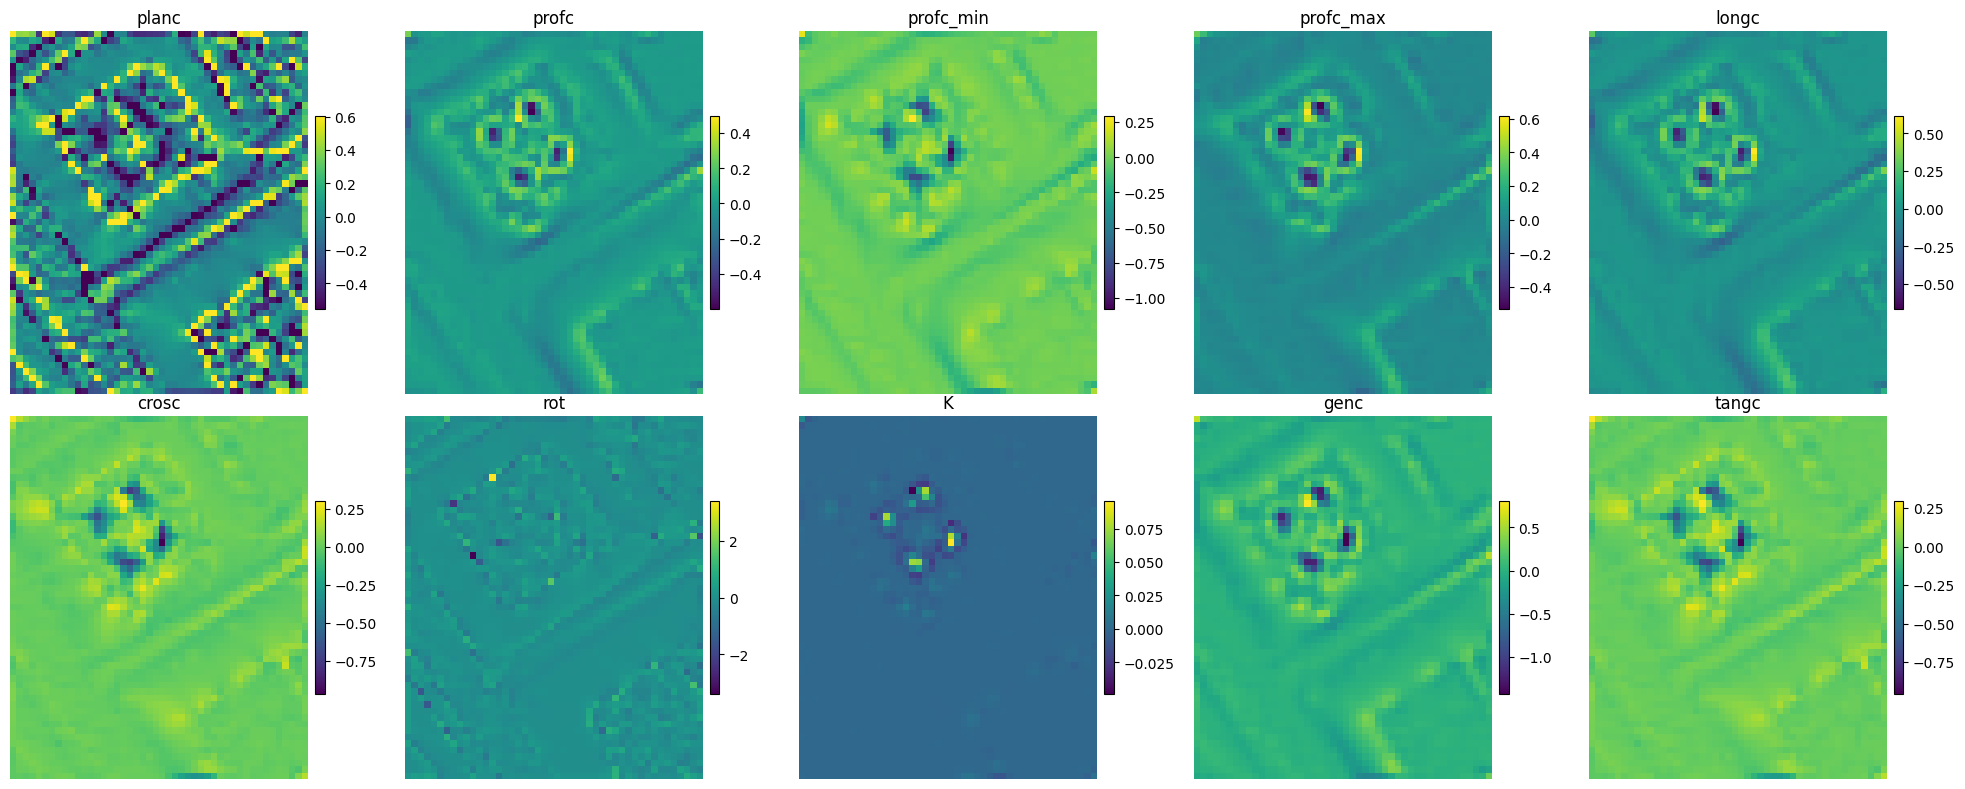

In [12]:
# Plotting
plots_side_by_side(5, 5, 
                   ("planc", nodata_to_nan(planc_clip, nodata_replacement)), 
                   ("profc", nodata_to_nan(profc, nodata_replacement)), 
                   ("profc_min", nodata_to_nan(profc_min, nodata_replacement)), 
                   ("profc_max", nodata_to_nan(profc_max, nodata_replacement)), 
                   ("longc", nodata_to_nan(longc, nodata_replacement)), 
                   ("crosc", nodata_to_nan(crosc, nodata_replacement)), 
                   ("rot", nodata_to_nan(rot, nodata_replacement)), 
                   ("K", nodata_to_nan(K, nodata_replacement)), 
                   ("genc", nodata_to_nan(genc, nodata_replacement)), 
                   ("tangc", nodata_to_nan(tangc, nodata_replacement)))

In [13]:
# Export 
export = False
export_raster(planc, f"young_{results_basename}_planc", second_order["planc"][1], export=export)
export_raster(profc, f"young_{results_basename}_profc", second_order["profc"][1], export=export)
export_raster(profc_min, f"young_{results_basename}_profc_min", second_order["profc_min"][1], export=export)
export_raster(profc_max, f"young_{results_basename}_profc_max", second_order["profc_max"][1], export=export)
export_raster(longc, f"young_{results_basename}_longc", second_order["longc"][1], export=export)
export_raster(crosc, f"young_{results_basename}_crosc", second_order["crosc"][1], export=export)
export_raster(rot, f"young_{results_basename}_rot", second_order["rot"][1], export=export)
export_raster(K, f"young_{results_basename}_K", second_order["K"][1], export=export)
export_raster(genc, f"young_{results_basename}_genc", second_order["genc"][1], export=export)
export_raster(tangc, f"young_{results_basename}_tangc", second_order["tangc"][1], export=export)


#### Evans (1979)

In [14]:
second_order = second_order_basic_set(raster, parameters=["planc", "profc", "profc_min", "profc_max", "longc", "crosc", "rot", "K", "genc", "tangc"], method="Evans")

planc = second_order["planc"][0]
profc = second_order["profc"][0]
profc_min = second_order["profc_min"][0]
profc_max = second_order["profc_max"][0]
longc = second_order["longc"][0]
crosc = second_order["crosc"][0]
rot = second_order["rot"][0]
K =  second_order["K"][0]
genc = second_order["genc"][0]
tangc = second_order["tangc"][0]

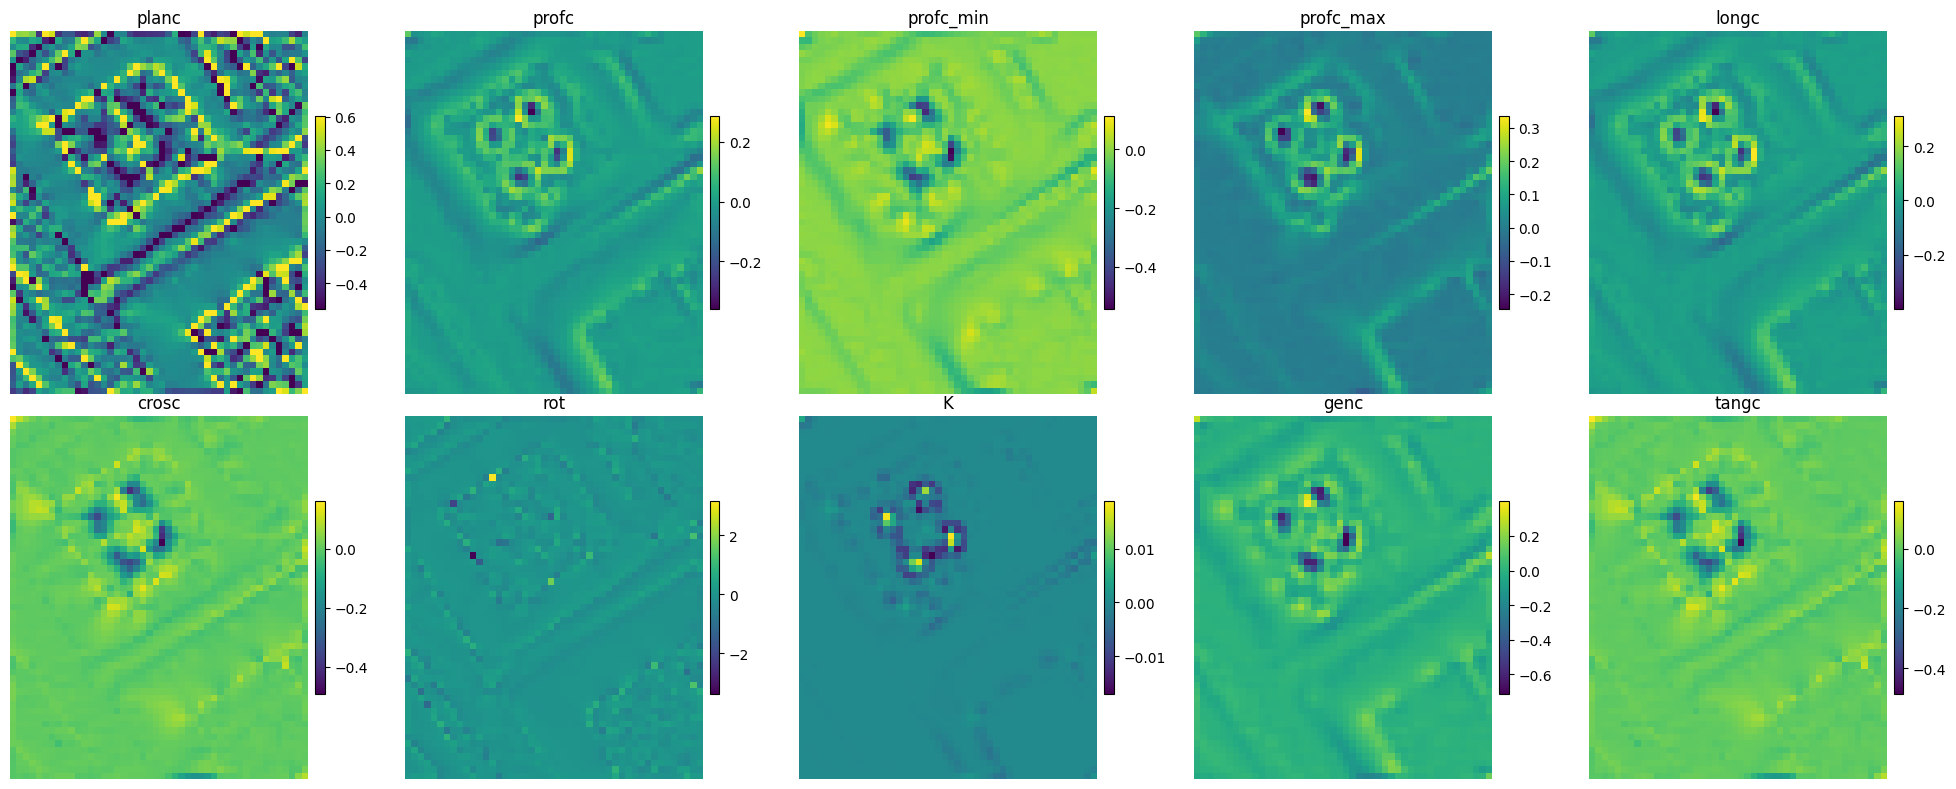

In [15]:
# Plotting
plots_side_by_side(5, 5, 
                   ("planc", nodata_to_nan(planc_clip, nodata_replacement)), 
                   ("profc", nodata_to_nan(profc, nodata_replacement)), 
                   ("profc_min", nodata_to_nan(profc_min, nodata_replacement)), 
                   ("profc_max", nodata_to_nan(profc_max, nodata_replacement)), 
                   ("longc", nodata_to_nan(longc, nodata_replacement)), 
                   ("crosc", nodata_to_nan(crosc, nodata_replacement)), 
                   ("rot", nodata_to_nan(rot, nodata_replacement)), 
                   ("K", nodata_to_nan(K, nodata_replacement)), 
                   ("genc", nodata_to_nan(genc, nodata_replacement)), 
                   ("tangc", nodata_to_nan(tangc, nodata_replacement)))

In [16]:
# Export 
export = False
export_raster(planc, f"young_{results_basename}_planc", second_order["planc"][1], export=export)
export_raster(profc, f"young_{results_basename}_profc", second_order["profc"][1], export=export)
export_raster(profc_min, f"young_{results_basename}_profc_min", second_order["profc_min"][1], export=export)
export_raster(profc_max, f"young_{results_basename}_profc_max", second_order["profc_max"][1], export=export)
export_raster(longc, f"young_{results_basename}_longc", second_order["longc"][1], export=export)
export_raster(crosc, f"young_{results_basename}_crosc", second_order["crosc"][1], export=export)
export_raster(rot, f"young_{results_basename}_rot", second_order["rot"][1], export=export)
export_raster(K, f"young_{results_basename}_K", second_order["K"][1], export=export)
export_raster(genc, f"young_{results_basename}_genc", second_order["genc"][1], export=export)
export_raster(tangc, f"young_{results_basename}_tangc", second_order["tangc"][1], export=export)